# Final Project - Computer Graphics, COSC 6372

---

### Chad Weatherly

### Variational Autoencoder for Image Super-Sampling



The goal of this project is to create and train a variational autoencoder (VAE), that when given images of low resolution, can automatically generate a high resolution image.


In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt



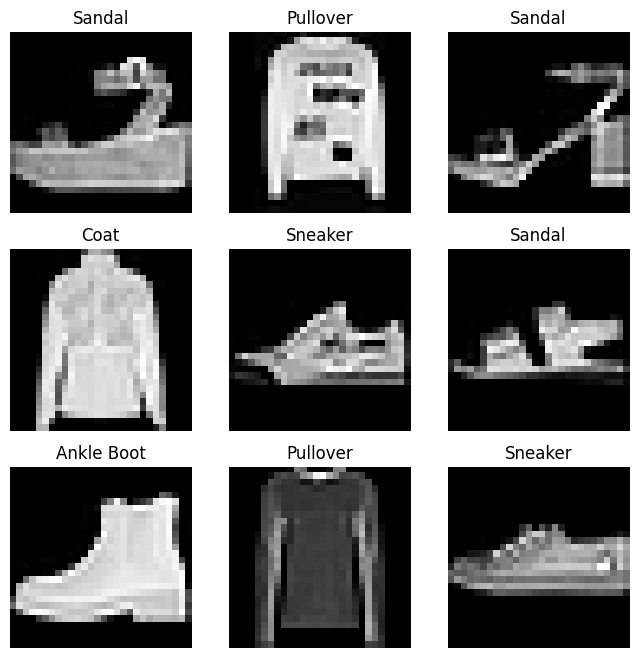

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Examples of data points
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
training_data[0][0].squeeze().shape

torch.Size([28, 28])

In [4]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [83]:
# Each image is 28 x 28
training_data[0][0].shape

# So, we want to create, for each data sample data[i], a tuple of 3 tensors, the regular (High Res) image, label, and the low res image (14 x 14)
# We don't really care about the label, though

def low_res(highres):
    """
    Given a tensor of shape (1, 28, 28), returns
    a lower resolution tensor of shape (1, 14, 14)
    """

    lr = torch.zeros((1, 14, 14))
    for i in range(14):
        for j in range(14):
            lr[0,i,j] = (highres[0,2*i,2*j] + highres[0,2*i+1,2*j] + highres[0,2*i,2*j+1] + highres[0,2*i+1,2*j+1]) / 4
    return lr


training_lr = []

for i in range(len(training_data)):
    training_lr.append(low_res(training_data[i][0]))

test_lr = []

for i in range(len(test_data)):
    test_lr.append(low_res(test_data[i][0]))

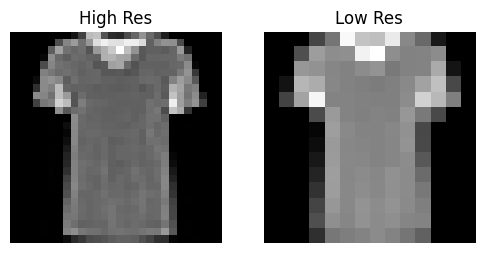

In [7]:
figure = plt.figure(figsize=(6, 6))

r = torch.randint(len(training_data), size=(1,)).item()

figure.add_subplot(1, 2, 1)
plt.title('High Res')
plt.axis("off")
plt.imshow(training_data[r][0].squeeze(), cmap="gray")

figure.add_subplot(1, 2, 2)
plt.title('Low Res')
plt.axis("off")
plt.imshow(low_res(training_data[r][0]).squeeze(), cmap="gray")

In [100]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define the Variational Convolutional Autoencoder class
class VarConvAE(nn.Module):
    def __init__(self, latent_dim, device):
        super(VarConvAE, self).__init__()

        # Define the latent dimension
        self.latent_dim = latent_dim
        self.N = torch.distributions.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim)) 
        self.device = device

        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),       # Output shape: (batch_size, 8, 28, 28)
            nn.ReLU(),                                       
            nn.MaxPool2d(kernel_size=2, stride=2),           # Output shape: (batch_size, 8, 14, 14)
            nn.Conv2d(8, 16, kernel_size=3, padding=1),      # Output shape: (batch_size, 16, 14, 14)
            nn.ReLU(),                                                                
            nn.Flatten(start_dim=0)                                   # Output shape: (batch_size, 64*49)
        )

        # Define the mean and logvar layers for the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Linear(64*49, self.latent_dim),
            nn.Tanh()
        )
        self.fc_var = nn.Sequential(
            nn.Linear(64*49, self.latent_dim),
            nn.Sigmoid()
        )

        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 14*14),                                                         # Output shape: (batch_size, 14*14)
            nn.Unflatten(0, (1, 14, 14)),                                                          # Output shape: (batch_size, 1, 14, 14)
            nn.ConvTranspose2d(1, 32, kernel_size=3, stride=2, padding=1, output_padding=1),      # Output shape: (batch_size, 32, 28, 28)
            nn.Flatten(start_dim=0, end_dim=-1),                                                                          # Output shape: (batch_size, 64*56*56)
            nn.ReLU(),                                                                            
            nn.Linear(32*28*28, 28*28),                                                            # Output shape: (batch_size, 28*28)
            nn.Sigmoid(),                                                                         
            nn.Unflatten(0, (1, 28, 28))                                                              # Output shape: (batch_size, 1, 28, 28)
        )
# (64x3136 and 100352x784)

    def encode(self, x):
        # Pass the input through the encoder layers
        x = self.encoder(x)

        # Compute the mean and logvar of the latent distribution
        mu = self.fc_mu(x)
        var = self.fc_var(x)

        return mu, var # each have size 196 (= 14 x 14)

    def reparameterize(self, mu, var):
        # Sample from the latent distribution using the reparameterization trick
        N_sample = self.N.rsample().to(self.device)
        std = torch.exp(0.5 * var)
        z = (mu + (N_sample.to(self.device) * std))

        z = nn.Sigmoid()(z)

        return z

    def decode(self, z):
        # Pass the latent representation through the decoder layers
        x = self.decoder(z)

        return x

    def forward(self, x):
        # Pass the input through the encoder layers to get the mean and logvar of the latent distribution
        mu, var = self.encode(x)

        # Sample from the latent distribution using the reparameterization trick
        z = self.reparameterize(mu, var)
        

        # Pass the latent representation through the decoder layers to get the reconstructed output
        x_recon = self.decode(z)

        return x_recon, z




Using cpu device


In [101]:
# MPS is the Mac M2 chip optimization, analogous to device='cuda' for NVIDIA GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ('Using MPS')
else:
    device='cpu'
    print ("MPS device not found.")
model = VarConvAE(latent_dim=14*14, device=device).to(device)
z = model(training_data[0][0].to(device))[1]

Using MPS


In [108]:
test_lr[0].shape

torch.Size([1, 14, 14])

In [109]:
nn.Unflatten(0, (1, 14, 14))(z).shape

torch.Size([1, 14, 14])

In [111]:
training_lr[0].shape

torch.Size([1, 14, 14])

In [192]:
# MPS is the Mac M2 chip optimization, analogous to device='cuda' for NVIDIA GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ('Using MPS')
else:
    device='cpu'
    print ("MPS device not found.")

device='cpu'

print()

# only if doing new model
new_model = False
path = 'saved_models/conv_vae.pt'

ld = 14*14
model = VarConvAE(latent_dim=ld, device=device)
print(model)

if new_model:
    total_loss = []
    total_recon_loss = []
    total_latent_loss = []

    test_loss = []
    test_recon_loss = []
    test_latent_loss = []
else:
    old_model = torch.load(path, map_location=device)

    model.load_state_dict(old_model[0])

    total_loss = old_model[1]
    total_recon_loss = old_model[2]
    total_latent_loss = old_model[3]

    test_loss = old_model[4]
    test_recon_loss = old_model[5]
    test_latent_loss = old_model[6]





### Training

# Set the model to train mode
model.train()
# model.to(device)

# Define the loss function and optimizer
objective_hr = nn.BCELoss(reduction='sum')
objective_lr = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

# Regularization Params
alpha = 0.25

num_epochs=3

for epoch in range(1, num_epochs+1):

    batch_loss = 0
    batch_latent_loss = 0
    batch_recon_loss = 0

    i_subset = np.random.choice(len(training_data), 10000, replace=False)
    count = 0

    # Loop over the training data
    for i, (x, y) in enumerate(training_data):
        if i not in i_subset:
            continue

        count += 1

        # Testing code
        # if i >= 5000:
        #     continue

        # Zero the gradients
        optimizer.zero_grad()

        x = x.to(device)

        # Pass the input through the model
        recon_img, z = model(x)

        recon_img.to(device)

        # Compute the reconstruction loss
        recon_loss = objective_hr(recon_img, x)
        batch_recon_loss += recon_loss.item()

        z = nn.Unflatten(0, (1, 14, 14))(z)
        latent_loss = objective_lr(z, training_lr[i])
        batch_latent_loss += latent_loss.item()

        # Compute the KL divergence loss
        # z.to('cpu')
        # N = torch.distributions.MultivariateNormal(torch.zeros(ld), torch.eye(ld)) 
        # log_px = N.log_prob(z)
        # px = log_px.exp()
        # log_px.to(device)
        # px.to(device)

        # q_x = torch.distributions.MultivariateNormal(mu, torch.eye(ld)*var) 
        # log_qx = q_x.log_prob(z)
        # log_qx.to(device)

        # kl_loss = (-1) * log_px.exp() * (log_px - log_qx)
        # batch_kl_loss += (kl_loss.item())

        # Compute the total loss
        loss = alpha*recon_loss + (1 - alpha)*latent_loss
        batch_loss += loss.item()
        
        # Backpropagate the gradients and update the weights
        loss.backward()
        optimizer.step()

        # Print the training progress every 100 images
        if count % 100 == 0 and count > 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAvg. Loss: {:.6f}'.format(
                epoch, count * len(x), len(i_subset),
                100. * count / len(i_subset),
                batch_loss / 100))
            print('Avg. Loss: Recon {:.2f}, Latent {:.2f}'.format(
                batch_recon_loss / 100, batch_latent_loss / 100
            ))

            total_loss.append(batch_loss / 100)
            total_recon_loss.append(batch_recon_loss / 100)
            total_latent_loss.append(batch_latent_loss / 100)

            batch_loss = 0
            batch_recon_loss = 0
            batch_latent_loss = 0



    ### Testing

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():

        temp_test_loss = 0
        temp_test_latent_loss = 0
        temp_test_recon_loss = 0

        i_subset = np.random.choice(len(test_data), 1000, replace=False)
        count = 0

        # Loop over the testing data
        for i, (x, y) in enumerate(test_data):
            if i not in i_subset:
                continue

            count += 1

            x = x.to(device)

            # Pass the input through the model
            recon_img, z = model(x)

            recon_img.to(device)

            # Compute the reconstruction loss
            recon_loss = objective_hr(recon_img, x)
            temp_test_recon_loss += recon_loss.item()

            z = nn.Unflatten(0, (1, 14, 14))(z)
            latent_loss = objective_lr(z, training_lr[i])
            temp_test_latent_loss += latent_loss.item()

            # Compute the total loss
            loss = alpha*recon_loss + (1 - alpha)*latent_loss
            temp_test_loss += loss.item()

            # Print the progress every 100 images
            if count % 100 == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    epoch, count * len(x), len(i_subset),
                    100. * count / len(i_subset)))

        print('Test Loss: {:.2f}'.format(temp_test_loss / len(i_subset)),
              'Test Recon Loss: {:.2f}'.format(temp_test_recon_loss / len(i_subset)),
              'Test Latent Loss: {:.2f}'.format(temp_test_latent_loss / len(i_subset)),
              sep="\n")
        print()
        
        test_loss.append(temp_test_loss / len(i_subset))
        test_recon_loss.append(temp_test_recon_loss / len(i_subset))
        test_latent_loss.append(temp_test_latent_loss / len(i_subset))

save_dict = dict()
save_dict[0] = model.state_dict()
save_dict[1] = total_loss
save_dict[2] = total_recon_loss
save_dict[3] = total_latent_loss
save_dict[4] = test_loss
save_dict[5] = test_recon_loss
save_dict[6] = test_latent_loss
torch.save(save_dict, path)

Using MPS

VarConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=0, end_dim=-1)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=3136, out_features=196, bias=True)
    (1): Sigmoid()
  )
  (fc_var): Sequential(
    (0): Linear(in_features=3136, out_features=196, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=196, out_features=196, bias=True)
    (1): Unflatten(dim=0, unflattened_size=(1, 14, 14))
    (2): ConvTranspose2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Flatten(start_dim=0, end_dim=-1)
    (4): ReLU()
    (5): Linear(in_features=25088, out_features=784, bias=True)
    (6): Sigmoid()
    (7): Unflatten(dim=0, unflattened_

<Figure size 640x480 with 0 Axes>

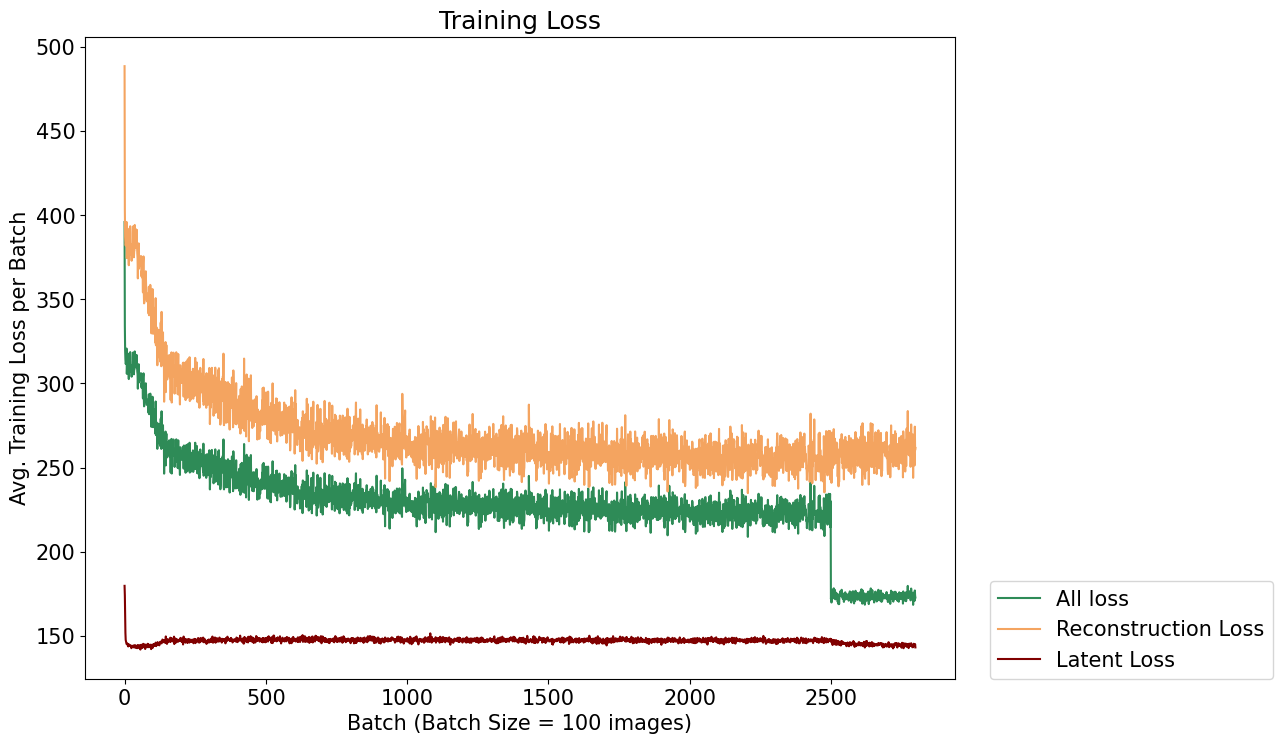

In [210]:
# Showing how the training loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Batch (Batch Size = 100 images)')
plt.ylabel('Avg. Training Loss per Batch')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

x_axis = np.arange(len(total_loss))
    
plt.plot(x_axis, total_loss, color='seagreen', label='All loss', lw=1.5)
plt.plot(x_axis, total_recon_loss, color='sandybrown', label='Reconstruction Loss', lw=1.5)
# plt.plot(x_axis, total_latent_loss, color='royalblue', label='All loss', lw=3)
plt.plot(x_axis, total_latent_loss, color='maroon', label='Latent Loss', lw=1.5)
    
plt.title('Training Loss')
plt.legend(loc=(1.04,0))

plt.savefig('charts/training_loss.png', bbox_inches='tight')

plt.show()

<Figure size 640x480 with 0 Axes>

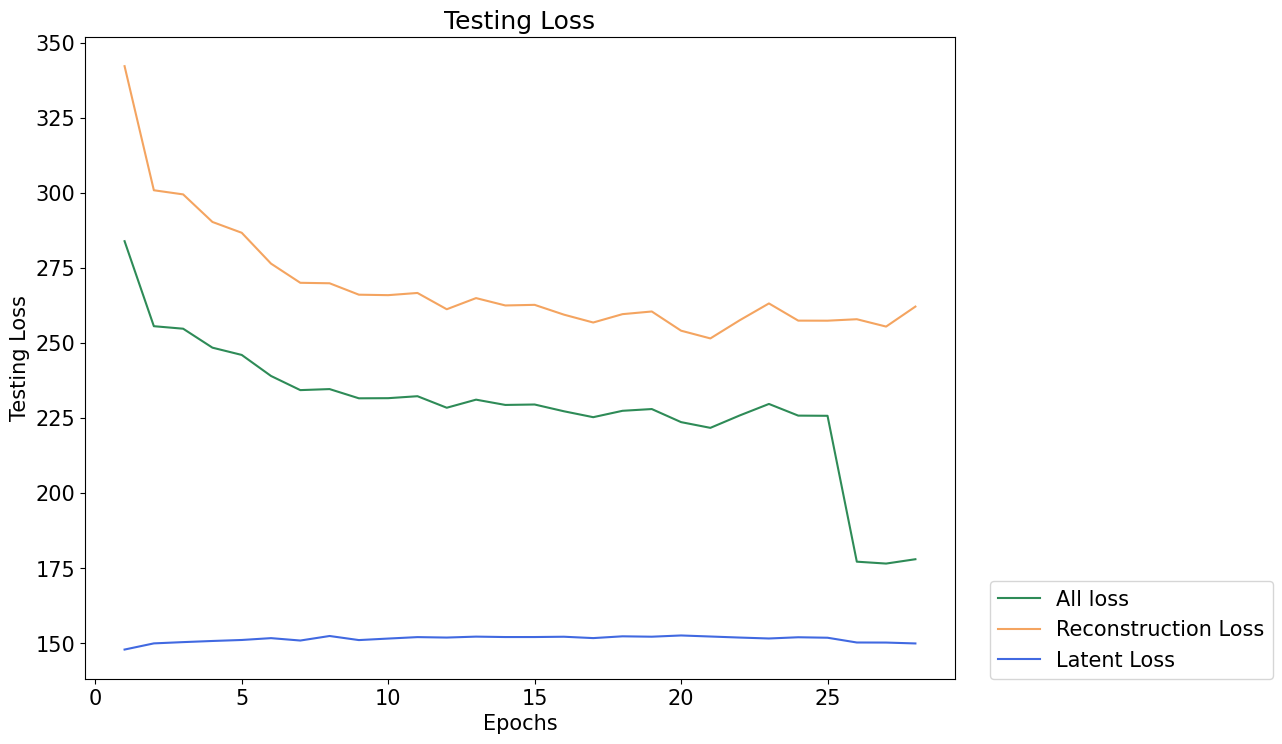

In [211]:
# Showing how the testing loss changes over epochs

plt.clf()
plt.figure(figsize=(10, 7.5))
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')

plt.tight_layout()
plt.rcParams.update({'font.size': 15})

x_axis = np.arange(1, len(test_loss)+1)
    
plt.plot(x_axis, test_loss, color='seagreen', label='All loss', lw=1.5)
plt.plot(x_axis, test_recon_loss, color='sandybrown', label='Reconstruction Loss', lw=1.5)
# plt.plot(x_axis, total_latent_loss, color='royalblue', label='All loss', lw=3)
plt.plot(x_axis, test_latent_loss, color='royalblue', label='Latent Loss', lw=1.5)
    
plt.title('Testing Loss')
plt.legend(loc=(1.04,0))

plt.savefig('charts/test_loss.png', bbox_inches='tight')

plt.show()

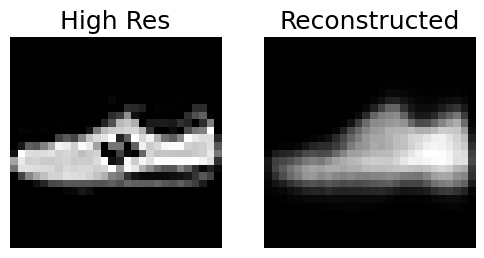

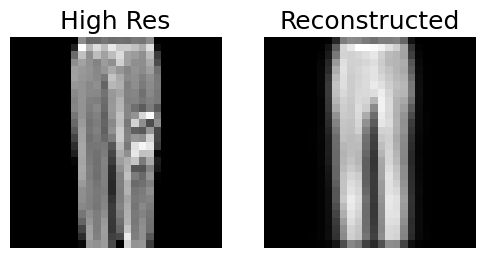

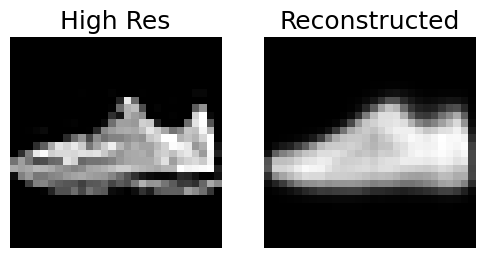

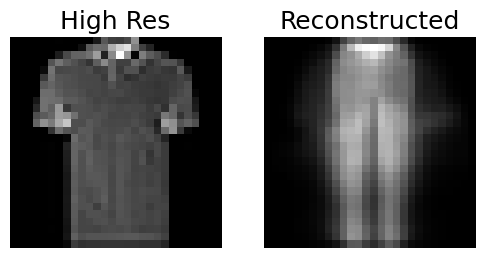

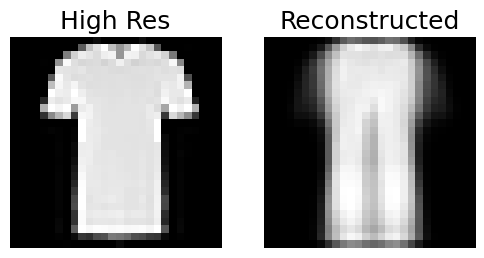

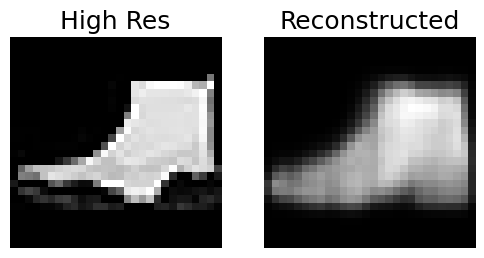

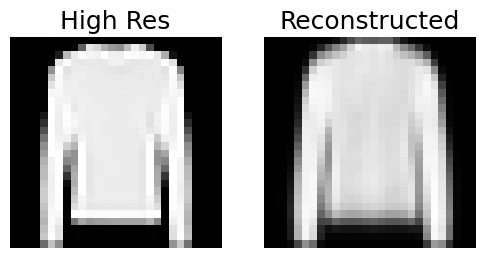

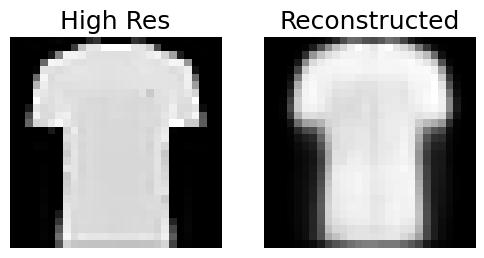

In [204]:
for i in range(8):

    figure = plt.figure(figsize=(6, 6))

    r = torch.randint(len(test_data), size=(1,)).item()

    figure.add_subplot(1, 2, 1)
    plt.title('High Res')
    plt.axis("off")
    plt.imshow(test_data[r][0].squeeze(), cmap="gray")

    figure.add_subplot(1, 2, 2)
    plt.title('Reconstructed')
    plt.axis("off")
    model.to('cpu')
    plt.imshow(model(test_data[r][0])[0].detach().numpy().squeeze(), cmap="gray")

    plt.savefig(f'charts/recon_from_hr_{i+1}.png')

    plt.show()

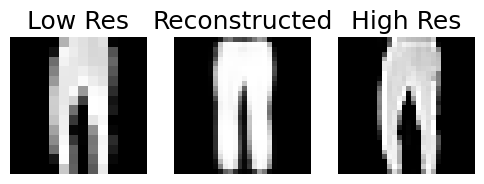

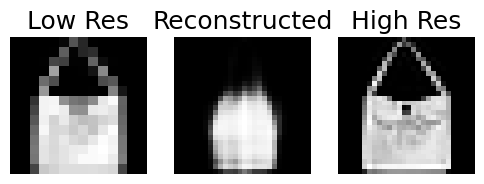

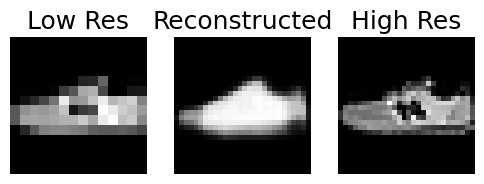

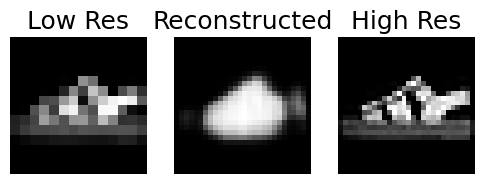

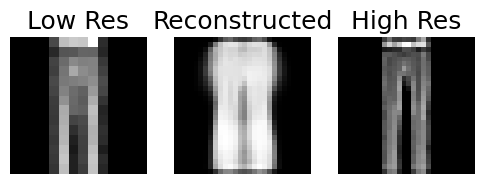

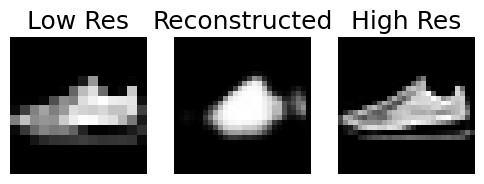

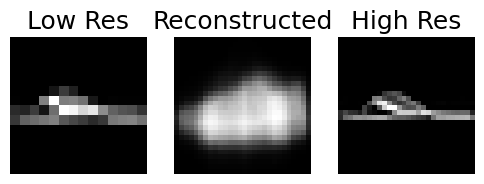

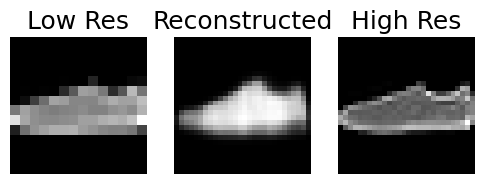

In [219]:
for i in range(8):

    figure = plt.figure(figsize=(6, 6))

    r = torch.randint(len(test_data), size=(1,)).item()

    figure.add_subplot(1, 3, 1)
    plt.title('Low Res')
    plt.axis("off")
    plt.imshow(test_lr[r].squeeze(), cmap="gray")

    figure.add_subplot(1, 3, 2)
    plt.title('Reconstructed')
    plt.axis("off")
    model.to('cpu')
    plt.imshow(model.decode(test_lr[r].flatten()).detach().numpy().squeeze(), cmap="gray")

    figure.add_subplot(1, 3, 3)
    plt.title('High Res')
    plt.axis("off")
    plt.imshow(test_data[r][0].squeeze(), cmap="gray")

    plt.savefig(f'charts/recon_from_lr_{i+1}.png')

    plt.show()